### Load data and add any columns by preprocessing the dataframe or merging with others

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, RepeatedKFold
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.utils import shuffle


data = pd.read_csv('Pollstar_all_genres.csv')
data['Event Date'] = pd.to_datetime(data['Event Date'])
data['day_of_week'] = data['Event Date'].dt.day_of_week
data['month'] = data['Event Date'].dt.month
data.head(3)

,Event Date,Number of Shows,Headliner,Support,Venue,City,State,Country,Market,Company Type,...,Genre,Avg. Tickets Sold,Avg. Gross USD,Avg. Event Capacity,Avg. Capacity Sold,Ticket Price Min USD,Ticket Price Max USD,Ticket Price Avg. USD,day_of_week,month
0,2024-09-18,1,Creed,"3 Doors Down, Finger Eleven",Coastal Credit Union Music Park at Walnut Creek,Raleigh,North Carolina,United States,Raleigh-Durham (Fayetteville),Amphitheatre,...,Pop / Rock,20295.0,1228939.0,20295.0,100%,39.5,225.0,60.55,2,9
1,2024-09-14,1,Creed,"3 Doors Down, Finger Eleven",The Cynthia Woods Mitchell Pavilion,The Woodlands,Texas,United States,Houston,Amphitheatre,...,Pop / Rock,16308.0,1374174.0,16308.0,100%,39.5,225.0,84.26,5,9
2,2024-09-13,1,Bruce Springsteen & The E Street Band,NaN,Oriole Park at Camden Yards,Baltimore,Maryland,United States,Baltimore,Stadium,...,Pop / Rock,39646.0,6556587.0,39646.0,100%,49.5,299.5,165.38,4,9


### Extract features that you are actually going to use

In [3]:
top_20_markets = data['Market'].value_counts().iloc[:20].index
one_hot_encoded = pd.get_dummies(data['Market'])
one_hot_encoded = one_hot_encoded[top_20_markets]
data = data.join(one_hot_encoded)

In [4]:
features = ['Avg. Event Capacity',
            'Ticket Price Min USD', 
            'Ticket Price Max USD',
            'day_of_week',
            'month'] + list(top_20_markets)

X = data[features]
y = data['Avg. Gross USD']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 8)

dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

### Test a model with repeated cross-validation to ensure the model's performance

In [9]:
# Choosing these hyperparameters can be done by randomized search cv or auto machine learning tool (FlaML)
# https://scikit-learn.org/1.5/modules/generated/sklearn.model_selection.RandomizedSearchCV.html
# https://microsoft.github.io/FLAML/
xgb_model = XGBRegressor(
    n_estimators=123,
    max_depth = 6,
    min_child_weight=6.775491524356438,
    learning_rate=0.2045492385700394,
    subsample=0.9538853360715174,
    colsample_bylevel=0.9843540929830947,
    colsample_bytree=0.7927149465668909,
    reg_alpha=0.05758042236618048,
    reg_lambda=5.778258009012479,
    objective='reg:squarederror',
    enable_categorical=True
)

In [10]:
# 5-fold CV repeated 10 times
rkf = RepeatedKFold(n_splits=5, n_repeats=10)

# Perform cross-validation to get MAE and R^2
mae_scores = cross_val_score(xgb_model, X_train, y_train, cv=rkf, scoring='neg_mean_absolute_error')
r2_scores = cross_val_score(xgb_model, X_train, y_train, cv=rkf, scoring='r2')


# NOTE MAE largely depends on the target distribution
print('Average MAE:', -np.mean(mae_scores))  # Negate since MAE is returned as negative
print('MAE Std Dev:', np.std(-mae_scores))
print('Average R^2:', np.mean(r2_scores))
print('R^2 Std Dev:', np.std(r2_scores))

Average MAE: 35800.11526586191
MAE Std Dev: 599.7214561529235
Average R^2: 0.778844719414894
R^2 Std Dev: 0.06195424499355604


In [5]:
features = ['Avg. Event Capacity',
            'Ticket Price Min USD', 
            'Ticket Price Max USD',
            'day_of_week',
            'month'] + list(top_20_markets)

X = data[features]
y = data['Avg. Gross USD']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 8)

dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

In [6]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 16776067687.860418
R^2 Score: 0.9002438778644194


In [7]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

random_search = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=param_grid,
    n_iter=10, 
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)

best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Best Parameters:", random_search.best_params_)
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None}
Mean Squared Error: 20325055174.76696
R^2 Score: 0.879140408577771


### Optional: When you want to see how the model performs on unseen data

In [10]:
rmse_scores = []
mae_scores = []
predictions = []

# Repeat the process 30 times
for i in range(30):
    X_train, y_train = shuffle(X_train, y_train, random_state=i)

    xgb_model = XGBRegressor(
        n_estimators=123,
        max_depth = 6,
        min_child_weight=6.775491524356438,
        learning_rate=0.2045492385700394,
        subsample=0.9538853360715174,
        colsample_bylevel=0.9843540929830947,
        colsample_bytree=0.7927149465668909,
        reg_alpha=0.05758042236618048,
        reg_lambda=5.778258009012479,
        objective='reg:squarederror',
        enable_categorical=True
    )
    
    
    xgb_model.fit(X_sample, y_sample)
    
    # Predict on the unseen data
    pred = xgb_model.predict(iu_X)
    
    # Calculate RMSE and MAE
    current_rmse = root_mean_squared_error(iu_y, pred)
    current_mae = mean_absolute_error(iu_y, pred)
    
    # Store the results
    rmse_scores.append(current_rmse)
    mae_scores.append(current_mae)
    predictions.append(pred)

print('Average RMSE over 30 iterations:', np.mean(rmse_scores))
print('RMSE Standard Deviation:', np.std(rmse_scores))
print('Average MAE over 30 iterations:', np.mean(mae_scores))
print('MAE Standard Deviation:', np.std(mae_scores))

NameError: name 'X_sample' is not defined

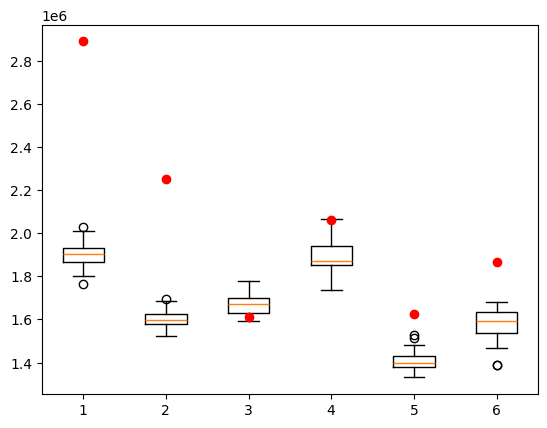

In [5]:
plt.boxplot(pd.DataFrame(predictions))
plt.scatter(range(1, len(iu_y) + 1), iu_y.values, color='red', zorder=3)
plt.show()

### For saving a model

In [6]:
import pickle

filename = 'model/example.pkl'

# Open the file to save the model
with open(filename, 'wb') as file:
    pickle.dump(xgb_model, file)